#  **ICT303 - Assignment 2**

**Your name: < Willie Chong Wei Yi>**

**Student ID: < 34388573>** 

**Email: < williecwy134@gmail.com>** 

In this assignment, you will build a deep learning model for identifying $120$ different breeds of dogs. Similar to the previous assignment, you will use real images from the [Kaggle competition](https://www.kaggle.com/c/dog-breed-identification). 

In this assignment, your are required to use a ResNet network. You can use ResNet implementation provided in PyTorch. Note however  that there are many versions of ResNet (they differ in terms of number of layers). Your task is to find the best configuration that gives the best performance. 

The rule is similar to the previous assignment:

1. Develop a better model to reduce the recognition error.  
2. Submit your results to Kaggle and take a sceenshot of your score. Then insert here the screenshot of your result. 

It is important that you start as earlier as possible. Tuning hyper-parameters takes time, and Kaggle limits the number of submissions per day.

The top 3 students in the Kaggle ranking will be invited for a coffee!

## **1. Obtaining and Organizing the Data Set**

The competition data is divided into a training set and testing set:
- The training set contains $10,222$ color images.
- The testing set contains $10,357$ color images. 

The images in both sets are in JPEG format. Each image contains three channels (R, G and B). The images have  different heights and widths.

There are $120$ breeds of dogs in the training set, e.g., *Labradors, Poodles, Dachshunds,
Samoyeds, Huskies, Chihuahuas, and Yorkshire Terriers*.

### **1.1. Downloading the Data Set**

After logging in to Kaggle, click on the “Data” tab on the dog breed identification competition webpage and download:
- the training data set `train.zip` and their corresponing labels `label.csv.zip`,
- the testing data set `test.zip`, 

After downloading the files, place them in the three paths below:
- kaggle_dog/train.zip
- kaggle_dog/test.zip
- kaggle_dog/labels.csv.zip

Run the code below to extract the data. 

In [1]:
#I have modified and created a seperate code, to make it easy for marking, that if the zip file is not extracted, it will extract it
import os #new code
import zipfile

data_dir = './kaggle_dog'

# Directories or file paths to check (new code)
check_paths = [os.path.join(data_dir, 'train'), os.path.join(data_dir, 'test'), os.path.join(data_dir, 'labels.csv')]

# Zip files corresponding to the directories or file paths
zipfiles = ['train.zip', 'test.zip', 'labels.csv.zip']

for check_path, zipfile_name in zip(check_paths, zipfiles):
    if not os.path.exists(check_path):
        # If the directory or file doesn't exist, extract it from the zip file
        with zipfile.ZipFile(os.path.join(data_dir, zipfile_name), 'r') as z:
            z.extractall(data_dir)
            print("File extracted: " + zipfile_name)
    else:
        print("File already extracted: " + zipfile_name)


File already extracted: train.zip
File already extracted: test.zip
File already extracted: labels.csv.zip


### **1.2. Organizing the Data Set**

Next, we define the reorg_train_valid function to split the validation set from the original Kaggle competition training set. The parameter valid_ratio in this function is the ratio of the number of examples of each dog breeds in the validation set to the number of examples of the
breed with the least examples (66) in the original training set. 

After organizing the data, images of the same breed will be placed in the same folder so that we can read them later.

In [2]:
import collections
import d2l
import shutil
import os
import math

#created my own mkdir_if_not_exist function, as no such function found in d2l api
def mkdir_if_not_exist(path):
    os.makedirs(os.path.join(*path), exist_ok=True)
    
def reorg_train_valid(data_dir, train_dir, input_dir, valid_ratio, idx_label):
  # The number of examples of the least represented breed in the training set.
  min_n_train_per_label = (
      collections.Counter(idx_label.values()).most_common()[:-2:-1][0][1])
  
  # The number of examples of each breed in the validation set.
  n_valid_per_label = math.floor(min_n_train_per_label * valid_ratio)
  label_count = {}
  for train_file in os.listdir(os.path.join(data_dir, train_dir)):
    idx = train_file.split('.')[0]
    label = idx_label[idx]

    #replace the d2l one with my own
    # d2l.mkdir_if_not_exist([data_dir, input_dir, 'train_valid', label])
    mkdir_if_not_exist([data_dir, input_dir, 'train_valid', label])

    shutil.copy(os.path.join(data_dir, train_dir, train_file),
                os.path.join(data_dir, input_dir, 'train_valid', label))
    
    if label not in label_count or label_count[label] < n_valid_per_label:
      #replace the d2l one with my own
      # d2l.mkdir_if_not_exist([data_dir, input_dir, 'valid', label])
      mkdir_if_not_exist([data_dir, input_dir, 'valid', label])
      shutil.copy(os.path.join(data_dir, train_dir, train_file),
                  os.path.join(data_dir, input_dir, 'valid', label))
      label_count[label] = label_count.get(label, 0) + 1
      
    else:
      #replace the d2l one with my own
      # d2l.mkdir_if_not_exist([data_dir, input_dir, 'train', label])
      mkdir_if_not_exist([data_dir, input_dir, 'train', label])
      shutil.copy(os.path.join(data_dir, train_dir, train_file),
                  os.path.join(data_dir, input_dir, 'train', label))

The `reorg_dog_data` function below is used to read the training data labels, segment the validation set, and organize the training set.

In [3]:
def reorg_dog_data(data_dir, label_file, train_dir, test_dir, input_dir, valid_ratio):
  # Read the training data labels.
  with open(os.path.join(data_dir, label_file), 'r') as f:
    # Skip the file header line (column name).
    lines = f.readlines()[1:]
    tokens = [l.rstrip().split(',') for l in lines]
    idx_label = dict(((idx, label) for idx, label in tokens))
  
  reorg_train_valid(data_dir, train_dir, input_dir, valid_ratio, idx_label)

  # Organize the training set.
  #replace the d2l one with my own
  # d2l.mkdir_if_not_exist([data_dir, input_dir, 'test', 'unknown'])
  mkdir_if_not_exist([data_dir, input_dir, 'test', 'unknown'])

  for test_file in os.listdir(os.path.join(data_dir, test_dir)):
    shutil.copy(os.path.join(data_dir, test_dir, test_file),
                os.path.join(data_dir, input_dir, 'test', 'unknown'))

During actual training and testing, we would use the entire Kaggle Competition data set and call the reorg_dog_data function to organize the data set. Likewise, we would need to set the batch_size to a larger integer, such as 128.

In [4]:
label_file, train_dir, test_dir = 'labels.csv', 'train', 'test'
input_dir, valid_ratio = 'train_valid_test', 0.1 #batch_size removed from the default provided code, declared later instead with training data
reorg_dog_data(data_dir, label_file, train_dir, test_dir, input_dir, valid_ratio)

In [7]:
#to verify if the number of images before and after re-org are same - to prevent miss out
def count_files_in_dir(dir_path):
    return sum([len(files) for _, _, files in os.walk(dir_path)])

def verify_reorg(original_dir, new_train_dir, new_valid_dir):
    original_files = count_files_in_dir(original_dir)
    new_files = count_files_in_dir(new_train_dir) + count_files_in_dir(new_valid_dir)

    if original_files == new_files:
        print(f"Reorganization verified. Original: {original_files}, New: {new_files}")
        return True
    else:
        print(f"Number of files don't match. Original: {original_files}, New: {new_files}")
        return False

# Now, verify your directories
verify_reorg(data_dir + '/train', data_dir + '/train_valid_test/train', data_dir + '/train_valid_test/valid')


Reorganization verified. Original: 10222, New: 10222


True

## **2. Image Augmentation**

Sometimes, when we do not have enough images to train our deep learning model, we data augmentation to simulate new data. For example, in the case of images, assume we only have $10$ images per class. We can create more instance by applying transformations to these images. For example, if the image is of a standin dog, we can rotate it $90$ and $180$ degrees to create two additional instances of the same dog. We can also scale it, etc.

Here are some more image augmentation operations that might be useful.

Start by training your model on the data set, the way it is provided. Then, think of the types of transformations you can apply to the training images to improve the performance. 

You can find more about how to apply transformations to images in this [link](https://pytorch.org/vision/stable/transforms.html).

In [5]:
import torch
import torchvision
from torchvision import transforms

transform_train = transforms.Compose([
    # Randomly crop a region and then resize it to be 224x224 pixels
    transforms.RandomResizedCrop(224),
    # Randomly flip the image horizontally
    transforms.RandomHorizontalFlip(),
    # Randomly jitter color and other transformations
    transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4),
    # Convert image to PyTorch tensor data type
    transforms.ToTensor(),
    # Normalize the image
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

transform_test = transforms.Compose([
    transforms.Resize(256),
    # Crop a centered 224x224 image region
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

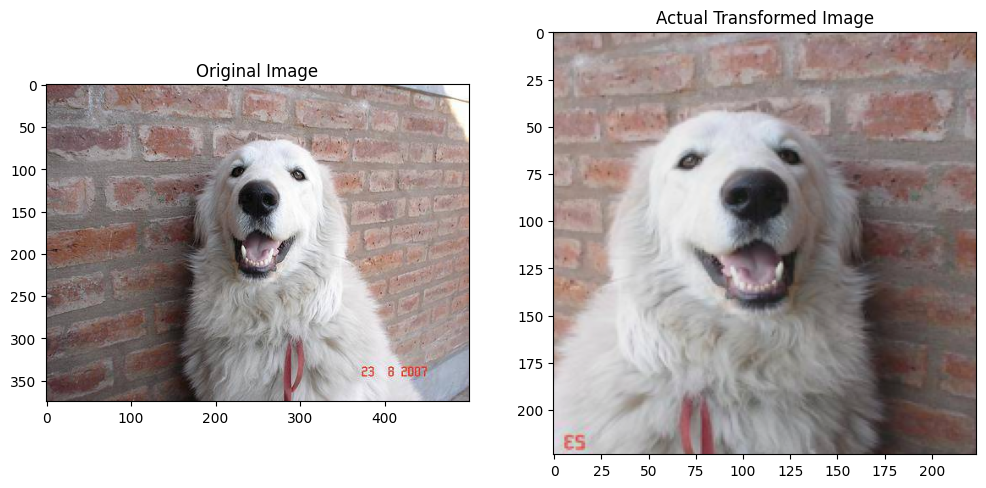

In [6]:
#testing the transform - trying to visualise the before and after transofmr image
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import torchvision.transforms.functional as F

# Let's take a single image from the dataset i have and open it
single_image_path = './kaggle_dog/train/0a0c223352985ec154fd604d7ddceabd.jpg'  # adjust path accordingly
image = Image.open(single_image_path)

# Testing out with the actual transform_train function with the single image i chose
def imshow_transformed(axis, image):
    # Convert PyTorch tensor to numpy array
    np_image = image.numpy()
    # Denormalize
    np_image = np_image * np.array([0.229, 0.224, 0.225]).reshape((3, 1, 1)) + np.array([0.485, 0.456, 0.406]).reshape((3, 1, 1))
    # Rearrange dimensions to (Height, Width, Channels)
    np_image = np.transpose(np_image, (1, 2, 0))
    # Clip values to be between 0 and 1
    np_image = np.clip(np_image, 0, 1)
    # Show image
    axis.imshow(np_image)

#apply transform_train to the image + convert to numpy array
transformed_train_image = transform_train(image)

# Show the original and transformed image
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Original
axs[0].imshow(image)
axs[0].set_title("Original Image")

#actual transformed image
imshow_transformed(axs[1], transformed_train_image)
axs[1].set_title("Actual Transformed Image")
plt.show()


## **3. Loading (Reading) the Data Set**

Similar to previous labs, write here the Python code tat reads the training, validation and test set.

In [7]:
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, Dataset

class ImageFolderWithPaths(ImageFolder):
    """Custom dataset that includes image file paths. Extends
    torchvision.datasets.ImageFolder
    """
    def __getitem__(self, index):
        original_tuple = super(ImageFolderWithPaths, self).__getitem__(index)
        path = self.imgs[index][0]
        tuple_with_path = (original_tuple + (path,))
        return tuple_with_path

# Define directories
train_dir = os.path.join(data_dir, input_dir, 'train')
valid_dir = os.path.join(data_dir, input_dir, 'valid')
test_dir = os.path.join(data_dir, input_dir, 'test')

# Create datasets
train_data = ImageFolder(root=train_dir, transform=transform_train)
valid_data = ImageFolder(root=valid_dir, transform=transform_test)
test_data = ImageFolderWithPaths(root=test_dir, transform=transform_test)  # here we use our custom dataset

# Create data loaders
batch_size = 16
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=4)
valid_loader = DataLoader(valid_data, batch_size=batch_size, shuffle=False, num_workers=4)
# test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)  # here we use our custom dataset


In [8]:
#checking the size of dataset
print(f"Number of training examples: {len(train_data)}")
print(f"Number of validation examples: {len(valid_data)}")
print(f"Number of testing examples: {len(test_data)}")

Number of training examples: 9502
Number of validation examples: 720
Number of testing examples: 10357


In [ ]:
import matplotlib.pyplot as plt

def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title, fontsize=20)
    plt.pause(0.001)  # pause a bit so that plots are updated

# Get a batch of training data
inputs, classes = next(iter(train_loader))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

class_names = train_data.classes
plt.figure(figsize=(200, 200))  # adjust the size as needed (width, height)
imshow(out, title=[class_names[x] for x in classes])

## **4. Defining and Training ResNet**

Here, you are required to use ResNet to recognise the breed of the dogs in the images. You need to write the class that defines the network, the training class and the code for training the network. You are not required to implement ResNet from scratch. Instead, use PyTorch's implementation of ResNet. 

Note that there are many versions of ResNet. They differ in the number of layers they use. You are required to test with at least 2 versions and report their respective performances. 

Note that you are required to follow the good practices when training your network. In particular, you need to look at the loss curves (training and validation losses).

### ResNet18 setup

In [14]:
#RESTNET18
import torch
import torch.nn as nn
from torchvision import models
import torch.optim as optim
import numpy as np

# Load pre-trained model
model = models.resnet18(pretrained=True)

# Replace the last layer to match the number of classes (original was designed for 1000 different classes)
num_classes = 120  # number of dog breeds
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, num_classes)

# Define a loss function - Cross Entropy - Commonly used for classification problems
criterion = nn.CrossEntropyLoss()

# Define an optimizer - starting learning rate 0.001
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# Define a learning rate scheduler - decrease learning rate by a factor of 10 every 10 epochs
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1) 


# Decide on device use - use GPU if available - Use MPS if available (for Mac) else cuda for window or colab else cpu
def get_device():
    print("Checking for GPU availability...")
    if torch.backends.mps.is_available():
        device = torch.device("mps")
    elif torch.cuda.is_available():
        device = torch.device("cuda")
    else:
        device = torch.device("cpu")
    return device

device = get_device()
#print out so user know which device is being used
print(f"Running on device: {device}")
model = model.to(device)

# Early stopping details
patience = 10
best_loss = np.inf
epochs_no_improve = 0
num_epochs = 20

# Training loop
for epoch in range(num_epochs):  

    # Training
    model.train()  # set the model to training mode
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device), data[1].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # Print training statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] training loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

    print(f'Epoch {epoch} current LR = {scheduler.get_last_lr()}')
    # One step of the scheduler (at the end of an epoch)
    scheduler.step()

    # Validation
    model.eval()  # set the model to evaluation mode
    with torch.no_grad():
        validation_loss = 0.0
        correct = 0
        total = 0
        for data in valid_loader:
            images, labels = data[0].to(device), data[1].to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            validation_loss += loss.item()
            
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        validation_loss = validation_loss / len(valid_loader)
        print(f'Epoch {epoch+1}, validation loss: {validation_loss}, Accuracy: {100 * correct / total}')

        # Check early stopping condition
        if validation_loss < best_loss:
            epochs_no_improve = 0
            best_loss = validation_loss
            torch.save(model.state_dict(), 'best_model.pth')
        else:
            epochs_no_improve += 1
            if epochs_no_improve == patience:
                print('Early stopping!')
                break
                
print('Finished Training')

Checking for GPU availability...
Running on device: cuda
Epoch 0 current LR = [0.001]
Epoch 1, validation loss: 1.598095428943634, Accuracy: 59.30555555555556
Epoch 1 current LR = [0.001]
Epoch 2, validation loss: 1.100465750032001, Accuracy: 67.36111111111111
Epoch 2 current LR = [0.001]
Epoch 3, validation loss: 0.9826018528805839, Accuracy: 72.08333333333333
Epoch 3 current LR = [0.001]
Epoch 4, validation loss: 0.8744850330882602, Accuracy: 72.63888888888889
Epoch 4 current LR = [0.001]
Epoch 5, validation loss: 0.8626455027196143, Accuracy: 73.61111111111111
Epoch 5 current LR = [0.001]
Epoch 6, validation loss: 0.8138694769806332, Accuracy: 75.13888888888889
Epoch 6 current LR = [0.001]
Epoch 7, validation loss: 0.824012291762564, Accuracy: 73.19444444444444
Epoch 7 current LR = [0.001]
Epoch 8, validation loss: 0.8019823071029452, Accuracy: 76.80555555555556
Epoch 8 current LR = [0.001]
Epoch 9, validation loss: 0.834412779741817, Accuracy: 74.30555555555556
Epoch 9 current LR =

### ResNet50 set up

In [ ]:
#RESTNET50
import torch
import torch.nn as nn
from torchvision import models
import torch.optim as optim
import numpy as np

# Load pre-trained model
model = models.resnet50(pretrained=True)

# Replace the last layer to match the number of classes (original was designed for 1000 different classes)
num_classes = 120  # number of dog breeds
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, num_classes)

# Define a loss function - Cross Entropy - Commonly used for classification problems
criterion = nn.CrossEntropyLoss()

# Define an optimizer
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# Decide on your device - use GPU if available - Use MPS if available (for Mac) else cuda else cpu
def get_device():
    print("Checking for GPU availability...")
    if torch.backends.mps.is_available():
        device = torch.device("mps")
    elif torch.cuda.is_available():
        device = torch.device("cuda")
    else:
        device = torch.device("cpu")
    return device

device = get_device()
#print out so user know which device is being used
print(f"Running on device: {device}")
model = model.to(device)

# Early stopping details
patience = 10
best_loss = np.inf
epochs_no_improve = 0
num_epochs = 20

# Training loop
for epoch in range(num_epochs):  

    # Training
    model.train()  # set the model to training mode
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device), data[1].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # Print training statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] training loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

    # Validation
    model.eval()  # set the model to evaluation mode
    with torch.no_grad():
        validation_loss = 0.0
        correct = 0
        total = 0
        for data in valid_loader:
            images, labels = data[0].to(device), data[1].to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            validation_loss += loss.item()
            
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        validation_loss = validation_loss / len(valid_loader)
        print(f'Epoch {epoch+1}, validation loss: {validation_loss}, Accuracy: {100 * correct / total}')

        # Check early stopping condition
        if validation_loss < best_loss:
            epochs_no_improve = 0
            best_loss = validation_loss
            torch.save(model.state_dict(), 'best_model.pth')
        else:
            epochs_no_improve += 1
            if epochs_no_improve == patience:
                print('Early stopping!')
                break
                
print('Finished Training')

## **6. Run on the Testing Set and Submit teh Results on Kaggle**

Finally, test your trained model on the test set and upload the results to the [Kaggle competition](https://www.kaggle.com/c/dog-breed-identification). 

You are required to submit a screenshot of your score.

In [15]:
import torch
import torch.nn.functional as F
import pandas as pd

# Step 1: Load the trained model
model = models.resnet18(pretrained=False)  # we don't need the pretrained weights
num_classes = 120
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, num_classes)

# load the best model
model.load_state_dict(torch.load('best_model.pth'))
model = model.to(device)

# Step 2: Preprocess the test data
# test_data is your test dataset
# test_loader = DataLoader(test_data, batch_size=32)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)  # here we use our custom dataset


# Step 3: Forward pass
model.eval()  # set the model to evaluation mode
results = []
with torch.no_grad():
#     for data in test_loader:
#         images = data[0].to(device)  # if ids are included in your test_data, replace this line with: images, ids = data[0].to(device), data[1]
#         outputs = model(images)
#         probabilities = F.softmax(outputs, dim=1)  # apply softmax to convert to probabilities
#         for id, probs in zip(ids, probabilities):
#             results.append([id] + probs.tolist())  # prepend id to the list of probabilities
    for images, _, paths in test_loader:  # paths are now included
        images = images.to(device)
        outputs = model(images)
        probabilities = F.softmax(outputs, dim=1)  # apply softmax to convert to probabilities
        for path, probs in zip(paths, probabilities):
            id = os.path.basename(path).split('.')[0]  # get the filename and remove the extension
            results.append([id] + probs.tolist())  # prepend id to the list of probabilities


# Extract class-to-index mapping and convert it to index-to-class
class_to_idx = train_data.class_to_idx
idx_to_class = {v: k for k, v in class_to_idx.items()}  

# Get list of breed names in the same order as in the training
list_of_breed_names = [idx_to_class[i] for i in range(len(idx_to_class))]

# Step 4: Write to CSV
df = pd.DataFrame(results, columns=['id'] + list_of_breed_names)
df.to_csv('submission.csv', index=False)

print("CSV file was created.")

CSV file was created.


## **7. Hints to Improve Your Results**
- Try to increase the batch size and the number of epochs.
- Try deeper ResNet networks.


# Testing with fixed LR - 0.001

## Testing ResNet 18 with different batch size + epochs

### Batch size 16

#### ResNet18 + Batch size 16 + 5 epochs

Epoch 1, validation loss: 1.5782539089520773, Accuracy: 62.083333333333336

Epoch 2, validation loss: 1.1042029486762153, Accuracy: 70.27777777777777

Epoch 3, validation loss: 0.9780496690008376, Accuracy: 70.69444444444444

Epoch 4, validation loss: 0.8683820254272885, Accuracy: 75.13888888888889

Epoch 5, validation loss: 0.9013861444261339, Accuracy: 73.19444444444444

Finished Training

Score = 0.87581

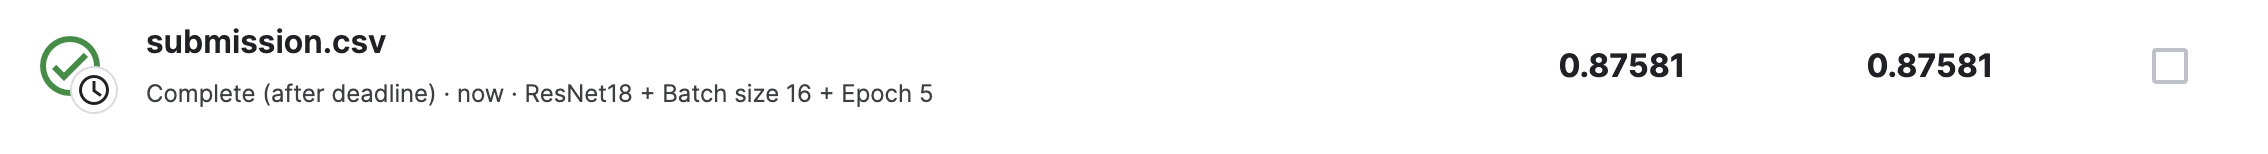

#### ResNet18 + Batch Size 16 + 10 Epochs

Score = 0.82882

Epoch 1, validation loss: 1.591970486111111, Accuracy: 58.75\
Epoch 2, validation loss: 1.0748413337601557, Accuracy: 71.11111111111111\
Epoch 3, validation loss: 0.9452253056897058, Accuracy: 72.36111111111111\
Epoch 4, validation loss: 0.9145324144098493, Accuracy: 72.22222222222223\
Epoch 5, validation loss: 0.8152314960956574, Accuracy: 76.11111111111111\
Epoch 6, validation loss: 0.7961405469311609, Accuracy: 75.27777777777777\
Epoch 7, validation loss: 0.8058430489566591, Accuracy: 77.08333333333333\
Epoch 8, validation loss: 0.7690309060944451, Accuracy: 77.08333333333333\
Epoch 9, validation loss: 0.7849790702263514, Accuracy: 74.58333333333333\
Epoch 10, validation loss: 0.7920924517843458, Accuracy: 76.25\
Finished Training


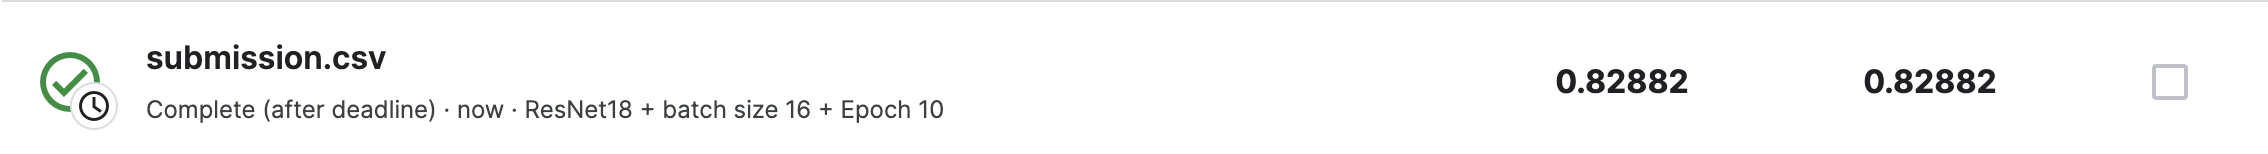


#### ResNet 18 + Batch Size 16 + 15 epochs
Epoch 1, validation loss: 1.5465114103423225, Accuracy: 63.75\
Epoch 2, validation loss: 1.1016679796907636, Accuracy: 69.30555555555556\
Epoch 3, validation loss: 0.9702805916468302, Accuracy: 70.83333333333333\
Epoch 4, validation loss: 0.8791906932989756, Accuracy: 73.05555555555556\
Epoch 5, validation loss: 0.8544077432817883, Accuracy: 73.47222222222223\
Epoch 6, validation loss: 0.8735847562551499, Accuracy: 73.05555555555556\
Epoch 7, validation loss: 0.8454309473435084, Accuracy: 75.55555555555556\
Epoch 8, validation loss: 0.8129304945468903, Accuracy: 76.11111111111111\
Epoch 9, validation loss: 0.8459885888629489, Accuracy: 73.88888888888889\
Epoch 10, validation loss: 0.8463581403096517, Accuracy: 74.44444444444444\
Epoch 11, validation loss: 0.8265006535583073, Accuracy: 74.86111111111111\
Epoch 12, validation loss: 0.8228550924195184, Accuracy: 74.72222222222223\
Epoch 13, validation loss: 0.8205011510186725, Accuracy: 74.44444444444444\
Epoch 14, validation loss: 0.7834424648020003, Accuracy: 75.83333333333333\
Epoch 15, validation loss: 0.7846580386161804, Accuracy: 76.11111111111111\
Finished Training

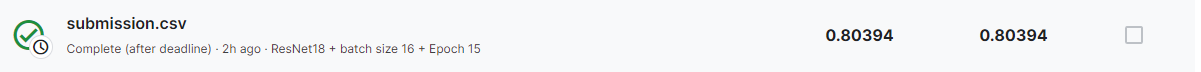

#### ResNet18 + Batch size 16 + 20 epochs

Epoch 1, validation loss: 1.5413263142108917, Accuracy: 61.52777777777778\
Epoch 2, validation loss: 1.0901872237523398, Accuracy: 69.58333333333333\
Epoch 3, validation loss: 0.9236855255232916, Accuracy: 74.02777777777777\
Epoch 4, validation loss: 0.8728799614641402, Accuracy: 74.58333333333333\
Epoch 5, validation loss: 0.8371646967199113, Accuracy: 75.41666666666667\
Epoch 6, validation loss: 0.8266291088528104, Accuracy: 74.16666666666667\
Epoch 7, validation loss: 0.8182052519586351, Accuracy: 73.47222222222223\
Epoch 8, validation loss: 0.8032254000504812, Accuracy: 74.16666666666667\
Epoch 9, validation loss: 0.7981712963845995, Accuracy: 74.86111111111111\
Epoch 10, validation loss: 0.8264651023679309, Accuracy: 73.47222222222223\
Epoch 11, validation loss: 0.7888816350036197, Accuracy: 75.27777777777777\
Epoch 12, validation loss: 0.8269423411952125, Accuracy: 73.75\
Epoch 13, validation loss: 0.7582627773284912, Accuracy: 77.08333333333333\
Epoch 14, validation loss: 0.7857452823056115, Accuracy: 75.69444444444444\
Epoch 15, validation loss: 0.7623781535360549, Accuracy: 76.52777777777777\
Epoch 16, validation loss: 0.7761531768573655, Accuracy: 74.72222222222223\
Epoch 17, validation loss: 0.8283746209409502, Accuracy: 73.75\
Epoch 18, validation loss: 0.8274461252821816, Accuracy: 74.30555555555556\
Epoch 19, validation loss: 0.8122788780265384, Accuracy: 74.30555555555556\
Epoch 20, validation loss: 0.8470998429589801, Accuracy: 75.41666666666667\
Finished Training

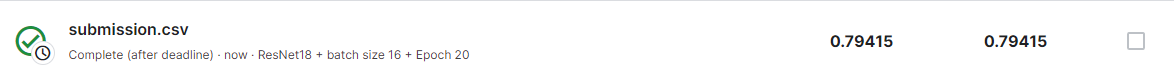


### Batch Size 32

#### ResNet18 + Batch size 32 + 5 epochs

Epoch 1, validation loss: 2.3206259478693423, Accuracy: 47.083333333333336\
Epoch 2, validation loss: 1.416329122107962, Accuracy: 68.33333333333333\
Epoch 3, validation loss: 1.14878866724346, Accuracy: 71.11111111111111\
Epoch 4, validation loss: 0.9889530980068705, Accuracy: 75.83333333333333\
Epoch 5, validation loss: 0.9031943860261337, Accuracy: 75.27777777777777\
Finished Training

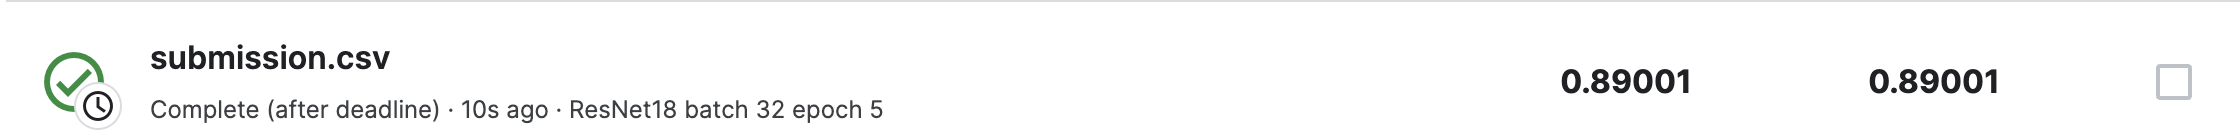

#### ResNet18 + Batch size 32 + 10 epochs

Epoch 1, validation loss: 2.3331505163856177, Accuracy: 49.861111111111114\
Epoch 2, validation loss: 1.4258201096368872, Accuracy: 69.30555555555556\
Epoch 3, validation loss: 1.1237026090207307, Accuracy: 72.91666666666667\
Epoch 4, validation loss: 0.9936712591544442, Accuracy: 74.02777777777777\
Epoch 5, validation loss: 0.9092777293661366, Accuracy: 75.41666666666667\
Epoch 6, validation loss: 0.8710885903109675, Accuracy: 75.69444444444444\
Epoch 7, validation loss: 0.819945084012073, Accuracy: 76.80555555555556\
Epoch 8, validation loss: 0.793395178473514, Accuracy: 77.08333333333333\
Epoch 9, validation loss: 0.739629715681076, Accuracy: 78.05555555555556\
Epoch 10, validation loss: 0.7506103321262028, Accuracy: 78.33333333333333\
Finished Training

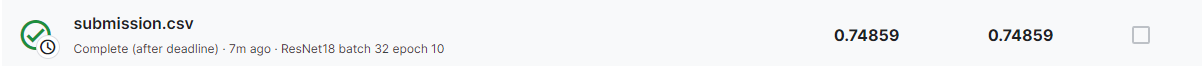

#### ResNet18 + Batch size 32 + 15 epochs

Epoch 1, validation loss: 2.3365475820458452, Accuracy: 48.19444444444444\
Epoch 2, validation loss: 1.461653823437898, Accuracy: 65.55555555555556\
Epoch 3, validation loss: 1.1503880982813628, Accuracy: 71.11111111111111\
Epoch 4, validation loss: 1.016331926636074, Accuracy: 75.41666666666667\
Epoch 5, validation loss: 0.9135505038758983, Accuracy: 75.27777777777777\
Epoch 6, validation loss: 0.8528634931730188, Accuracy: 75.13888888888889\
Epoch 7, validation loss: 0.8218928575515747, Accuracy: 77.77777777777777\
Epoch 8, validation loss: 0.7767925392026487, Accuracy: 77.63888888888889\
Epoch 9, validation loss: 0.7725955209006434, Accuracy: 77.63888888888889\
Epoch 10, validation loss: 0.7558218279610509, Accuracy: 78.75\
Epoch 11, validation loss: 0.7471923309823741, Accuracy: 78.61111111111111\
Epoch 12, validation loss: 0.7641845397327257, Accuracy: 77.08333333333333\
Epoch 13, validation loss: 0.717608630657196, Accuracy: 79.86111111111111\
Epoch 14, validation loss: 0.7402558741362198, Accuracy: 77.22222222222223\
Epoch 15, validation loss: 0.7327279940895413, Accuracy: 77.91666666666667\
Finished Training

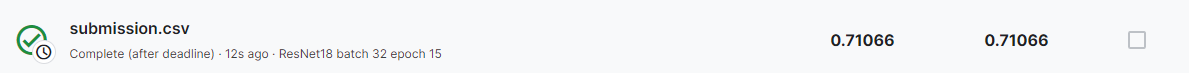

#### ResNet18 + Batch size 32 + 20 epochs

Epoch 1, validation loss: 2.374590013338172, Accuracy: 49.583333333333336\
Epoch 2, validation loss: 1.4531181480573572, Accuracy: 64.44444444444444\
Epoch 3, validation loss: 1.1238274522449658, Accuracy: 75.27777777777777\
Epoch 4, validation loss: 0.9665148906085802, Accuracy: 74.44444444444444\
Epoch 5, validation loss: 0.9012705398642499, Accuracy: 74.30555555555556\
Epoch 6, validation loss: 0.8533355101295139, Accuracy: 75.13888888888889\
Epoch 7, validation loss: 0.8196805054726808, Accuracy: 75.55555555555556\
Epoch 8, validation loss: 0.8014577756757322, Accuracy: 75.69444444444444\
Epoch 9, validation loss: 0.7864390857841658, Accuracy: 77.91666666666667\
Epoch 10, validation loss: 0.7551840984303019, Accuracy: 77.22222222222223\
Epoch 11, validation loss: 0.7613568007946014, Accuracy: 77.36111111111111\
Epoch 12, validation loss: 0.7304278262283491, Accuracy: 77.91666666666667\
Epoch 13, validation loss: 0.7265930953233138, Accuracy: 77.91666666666667\
Epoch 14, validation loss: 0.7111521466918613, Accuracy: 78.47222222222223\
Epoch 15, validation loss: 0.7017428952714672, Accuracy: 78.33333333333333\
Epoch 16, validation loss: 0.7124481304832126, Accuracy: 78.47222222222223\
Epoch 17, validation loss: 0.7174796773039777, Accuracy: 78.05555555555556\
Epoch 18, validation loss: 0.6954976799695388, Accuracy: 78.33333333333333\
Epoch 19, validation loss: 0.7008723266746687, Accuracy: 78.05555555555556\
Epoch 20, validation loss: 0.7444684324057206, Accuracy: 77.22222222222223\
Finished Training

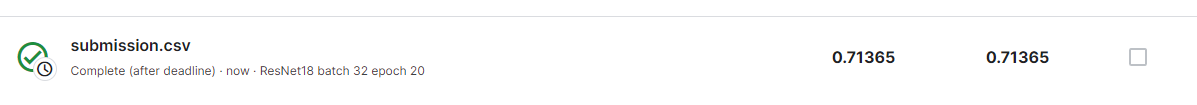

### Batch Size 64

#### ResNet18 + Batch size 64 + 5 epochs

Epoch 1, validation loss: 3.5197793443997702, Accuracy: 27.5\
Epoch 2, validation loss: 2.3475065926710763, Accuracy: 51.94444444444444\
Epoch 3, validation loss: 1.7508224149545033, Accuracy: 63.611111111111114\
Epoch 4, validation loss: 1.4276215533415477, Accuracy: 71.25\
Epoch 5, validation loss: 1.2209369391202927, Accuracy: 73.33333333333333\
Finished Training

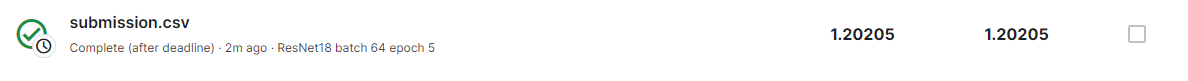

#### ResNet18 + Batch size 64 + 10 epochs

Epoch 1, validation loss: 3.423178215821584, Accuracy: 31.666666666666668\
Epoch 2, validation loss: 2.2735435167948403, Accuracy: 53.611111111111114\
Epoch 3, validation loss: 1.6853626271088917, Accuracy: 65.27777777777777\
Epoch 4, validation loss: 1.3946128884951274, Accuracy: 70.41666666666667\
Epoch 5, validation loss: 1.213925873239835, Accuracy: 73.19444444444444\
Epoch 6, validation loss: 1.096721773346265, Accuracy: 74.02777777777777\
Epoch 7, validation loss: 1.0109848181406658, Accuracy: 75.83333333333333\
Epoch 8, validation loss: 0.9510957449674606, Accuracy: 77.22222222222223\
Epoch 9, validation loss: 0.9238417198260626, Accuracy: 76.66666666666667\
Epoch 10, validation loss: 0.8739611357450485, Accuracy: 77.36111111111111\
Finished Training

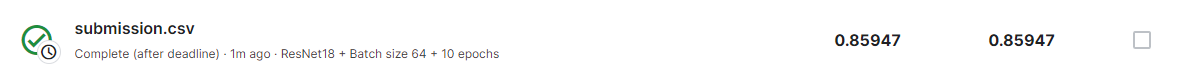

#### ResNet18 + Batch size 64 + 15 epochs

Epoch 1, validation loss: 3.4301886558532715, Accuracy: 30.416666666666668\
Epoch 2, validation loss: 2.2701187630494437, Accuracy: 54.166666666666664\
Epoch 3, validation loss: 1.6820792059103649, Accuracy: 62.22222222222222\
Epoch 4, validation loss: 1.369893620411555, Accuracy: 69.16666666666667\
Epoch 5, validation loss: 1.2099605550368626, Accuracy: 70.97222222222223\
Epoch 6, validation loss: 1.0812286486228306, Accuracy: 72.36111111111111\
Epoch 7, validation loss: 0.9814909249544144, Accuracy: 75.27777777777777\
Epoch 8, validation loss: 0.9440357089042664, Accuracy: 75.55555555555556\
Epoch 9, validation loss: 0.9036321391661962, Accuracy: 76.80555555555556\
Epoch 10, validation loss: 0.848854586482048, Accuracy: 77.77777777777777\
Epoch 11, validation loss: 0.8232021381457647, Accuracy: 78.05555555555556\
Epoch 12, validation loss: 0.8055895815292994, Accuracy: 77.77777777777777\
Epoch 13, validation loss: 0.7796695580085119, Accuracy: 78.75\
Epoch 14, validation loss: 0.7741465419530869, Accuracy: 78.47222222222223\
Epoch 15, validation loss: 0.759532555937767, Accuracy: 78.88888888888889\
Finished Training

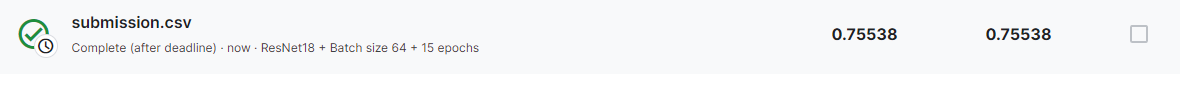

#### ResNet18 + Batch size 64 + 20 epochs

Epoch 1, validation loss: 3.423655152320862, Accuracy: 31.38888888888889\
Epoch 2, validation loss: 2.263794720172882, Accuracy: 54.166666666666664\
Epoch 3, validation loss: 1.6949596206347148, Accuracy: 65.13888888888889\
Epoch 4, validation loss: 1.3994768460591633, Accuracy: 70.0\
Epoch 5, validation loss: 1.2003989567359288, Accuracy: 71.38888888888889\
Epoch 6, validation loss: 1.0929984152317047, Accuracy: 73.47222222222223\
Epoch 7, validation loss: 1.0237351854642232, Accuracy: 75.83333333333333\
Epoch 8, validation loss: 0.9381516128778458, Accuracy: 75.13888888888889\
Epoch 9, validation loss: 0.9098073989152908, Accuracy: 76.66666666666667\
Epoch 10, validation loss: 0.8677212248245875, Accuracy: 76.80555555555556\
Epoch 11, validation loss: 0.8271002123753229, Accuracy: 78.33333333333333\
Epoch 12, validation loss: 0.8227589875459671, Accuracy: 77.63888888888889\
Epoch 13, validation loss: 0.7913761089245478, Accuracy: 77.77777777777777\
Epoch 14, validation loss: 0.7559085190296173, Accuracy: 79.16666666666667\
Epoch 15, validation loss: 0.7596270740032196, Accuracy: 78.47222222222223\
Epoch 16, validation loss: 0.7454224129517873, Accuracy: 79.72222222222223\
Epoch 17, validation loss: 0.7399104783932368, Accuracy: 78.05555555555556\
Epoch 18, validation loss: 0.737035483121872, Accuracy: 78.47222222222223\
Epoch 19, validation loss: 0.7389402290185293, Accuracy: 78.47222222222223\
Epoch 20, validation loss: 0.7042622764905294, Accuracy: 79.58333333333333\
Finished Training

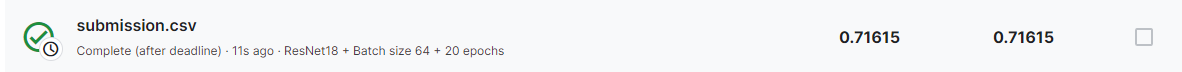

#### ResNet18 + Batch size 64 + 30 epochs

Epoch 1, validation loss: 3.458740492661794, Accuracy: 29.583333333333332\
Epoch 2, validation loss: 2.2916979690392814, Accuracy: 54.72222222222222\
Epoch 3, validation loss: 1.6945397158463795, Accuracy: 63.888888888888886\
Epoch 4, validation loss: 1.4086078802744548, Accuracy: 68.88888888888889\
Epoch 5, validation loss: 1.2398742387692134, Accuracy: 71.80555555555556\
Epoch 6, validation loss: 1.103844866156578, Accuracy: 73.61111111111111\
Epoch 7, validation loss: 1.0416528383890789, Accuracy: 73.47222222222223\
Epoch 8, validation loss: 0.9563458313544592, Accuracy: 75.55555555555556\
Epoch 9, validation loss: 0.9071904867887497, Accuracy: 76.52777777777777\
Epoch 10, validation loss: 0.8824589053789774, Accuracy: 74.72222222222223\
Epoch 11, validation loss: 0.8358027140299479, Accuracy: 78.19444444444444\
Epoch 12, validation loss: 0.8156855950752894, Accuracy: 77.5\
Epoch 13, validation loss: 0.8165840059518814, Accuracy: 77.36111111111111\
Epoch 14, validation loss: 0.7825663834810257, Accuracy: 78.05555555555556\
Epoch 15, validation loss: 0.7671574503183365, Accuracy: 78.75\
Epoch 16, validation loss: 0.7637352223197619, Accuracy: 78.33333333333333\
Epoch 17, validation loss: 0.743331159154574, Accuracy: 77.77777777777777\
Epoch 18, validation loss: 0.7426600406567255, Accuracy: 78.33333333333333\
Epoch 19, validation loss: 0.7226380705833435, Accuracy: 78.05555555555556\
Epoch 20, validation loss: 0.7145857190092405, Accuracy: 78.88888888888889\
Epoch 21, validation loss: 0.7124829217791557, Accuracy: 79.72222222222223\
Epoch 22, validation loss: 0.7005427976449331, Accuracy: 80.69444444444444\
Epoch 23, validation loss: 0.6952733273307482, Accuracy: 80.0\
Epoch 24, validation loss: 0.7028336649139723, Accuracy: 78.61111111111111\
Epoch 25, validation loss: 0.6866119106610616, Accuracy: 78.61111111111111\
Epoch 26, validation loss: 0.6882202426592509, Accuracy: 79.86111111111111\
Epoch 27, validation loss: 0.6846163868904114, Accuracy: 78.47222222222223\
Epoch 28, validation loss: 0.6797247330347697, Accuracy: 78.75\
Epoch 29, validation loss: 0.6782194823026657, Accuracy: 78.33333333333333\
Epoch 30, validation loss: 0.686409999926885, Accuracy: 79.44444444444444\
Finished Training

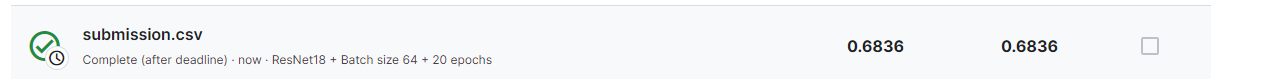

Typo for the description


## Testing ResNet 50 with different batch size + epochs

### Batch size 16

#### Attempt 1: Starting with ResNet50 + Batch size 16 + 5 epochs

Epoch 1, validation loss: 0.9241547359360589, Accuracy: 75.41666666666667\
Epoch 2, validation loss: 0.6934672719902463, Accuracy: 79.02777777777777\
Epoch 3, validation loss: 0.6238312297397189, Accuracy: 79.44444444444444\
Epoch 4, validation loss: 0.6269466790888044, Accuracy: 80.97222222222223\
Epoch 5, validation loss: 0.6527126850353346, Accuracy: 79.16666666666667\
Finished Training

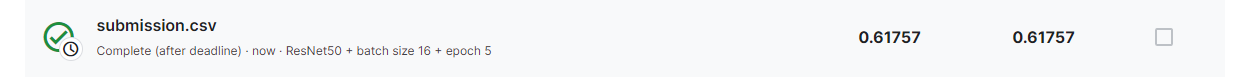

#### Attempt 2: ResNet50 + Batch size 16 + 10 epochs

Epoch 1, validation loss: 0.9326940483517117, Accuracy: 77.77777777777777\
Epoch 2, validation loss: 0.7310715549521976, Accuracy: 79.72222222222223\
Epoch 3, validation loss: 0.6660105758243137, Accuracy: 78.88888888888889\
Epoch 4, validation loss: 0.6566710581382116, Accuracy: 79.72222222222223\
Epoch 5, validation loss: 0.7081123699744543, Accuracy: 77.77777777777777\
Epoch 6, validation loss: 0.6452958110305999, Accuracy: 79.02777777777777\
Epoch 7, validation loss: 0.6003631180359258, Accuracy: 82.36111111111111\
Epoch 8, validation loss: 0.633194825053215, Accuracy: 80.13888888888889\
Epoch 9, validation loss: 0.7053441368871265, Accuracy: 77.5\
Epoch 10, validation loss: 0.692426028682126, Accuracy: 78.33333333333333\
Finished Training

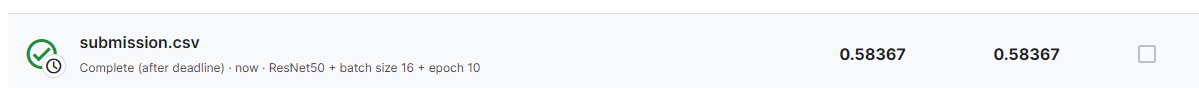

#### Attempt 3: ResNet50 + Batch size 16 + 15 epochs
Epoch 1, validation loss: 1.025272454155816, Accuracy: 73.75\
Epoch 2, validation loss: 0.7132708291212718, Accuracy: 79.44444444444444\
Epoch 3, validation loss: 0.6309081388844384, Accuracy: 81.25\
Epoch 4, validation loss: 0.6542240391174953, Accuracy: 81.11111111111111\
Epoch 5, validation loss: 0.5935542023844189, Accuracy: 81.94444444444444\
Epoch 6, validation loss: 0.6172170072793961, Accuracy: 79.58333333333333\
Epoch 7, validation loss: 0.5924389201733801, Accuracy: 81.66666666666667\
Epoch 8, validation loss: 0.6401166689064768, Accuracy: 79.86111111111111\
Epoch 9, validation loss: 0.6663292600048913, Accuracy: 78.75\
Epoch 10, validation loss: 0.6450423111518224, Accuracy: 80.27777777777777\
Epoch 11, validation loss: 0.586467507812712, Accuracy: 81.38888888888889\
Epoch 12, validation loss: 0.6311916788419087, Accuracy: 81.25\
Epoch 13, validation loss: 0.6808847135967678, Accuracy: 80.13888888888889\
Epoch 14, validation loss: 0.61123279614581, Accuracy: 80.13888888888889\
Epoch 15, validation loss: 0.6225934471521113, Accuracy: 80.41666666666667\
Finished Training

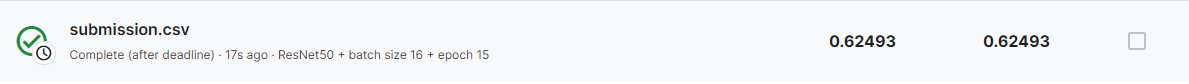

#### Attempt 4: ResNet50 + Batch size 16 + 20 epochs

Epoch 1, validation loss: 0.9122523890601264, Accuracy: 78.75\
Epoch 2, validation loss: 0.7312033474445343, Accuracy: 77.36111111111111\
Epoch 3, validation loss: 0.6452704048819012, Accuracy: 80.83333333333333\
Epoch 4, validation loss: 0.6572421123584111, Accuracy: 79.72222222222223\
Epoch 5, validation loss: 0.608006727695465, Accuracy: 81.38888888888889\
Epoch 6, validation loss: 0.6238394834929042, Accuracy: 81.52777777777777\
Epoch 7, validation loss: 0.6025934487581253, Accuracy: 80.83333333333333\
Epoch 8, validation loss: 0.6507349337140719, Accuracy: 79.44444444444444\
Epoch 9, validation loss: 0.6740533540646235, Accuracy: 77.63888888888889\
Epoch 10, validation loss: 0.6172816673914592, Accuracy: 82.22222222222223\
Epoch 11, validation loss: 0.6603665620088577, Accuracy: 79.44444444444444\
Epoch 12, validation loss: 0.7426142272022035, Accuracy: 78.19444444444444\
Epoch 13, validation loss: 0.6945873116453488, Accuracy: 79.16666666666667\
Epoch 14, validation loss: 0.647246924870544, Accuracy: 80.55555555555556\
Epoch 15, validation loss: 0.6811901912093162, Accuracy: 77.77777777777777\
Epoch 16, validation loss: 0.6704635446270307, Accuracy: 79.72222222222223\
Epoch 17, validation loss: 0.7080929989616076, Accuracy: 80.13888888888889\
Early stopping!\
Finished Training


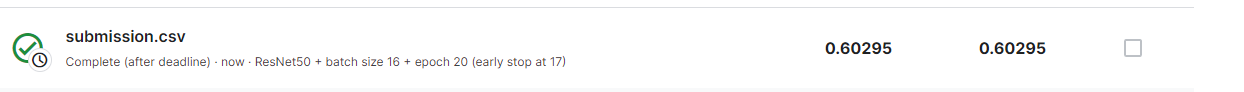


### Batch Size 32

#### Attempt 1 (Increased batch size 16-> 32): Starting with ResNet50 + Batch size 32 + 5 epochs
Epoch 1, validation loss: 1.5816064554712046, Accuracy: 69.44444444444444\
Epoch 2, validation loss: 0.8460582753886348, Accuracy: 81.11111111111111\
Epoch 3, validation loss: 0.6791295150051946, Accuracy: 81.66666666666667\
Epoch 4, validation loss: 0.5939281518044679, Accuracy: 83.05555555555556\
Epoch 5, validation loss: 0.5920678493769272, Accuracy: 81.66666666666667\
Finished Training

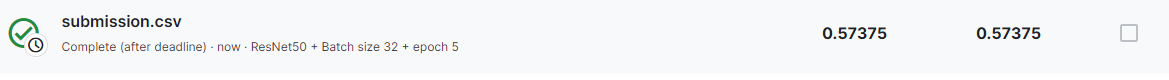

#### Attempt 2: ResNet50 + Batch size 32 + 10 epochs

Epoch 1, validation loss: 1.5336602071057195, Accuracy: 72.08333333333333\
Epoch 2, validation loss: 0.8549504409665647, Accuracy: 80.0\
Epoch 3, validation loss: 0.7003122529257899, Accuracy: 81.94444444444444\
Epoch 4, validation loss: 0.6198628985363505, Accuracy: 82.08333333333333\
Epoch 5, validation loss: 0.5664309146611587, Accuracy: 83.19444444444444\
Epoch 6, validation loss: 0.5300589333409849, Accuracy: 84.30555555555556\
Epoch 7, validation loss: 0.5054568000461744, Accuracy: 84.86111111111111\
Epoch 8, validation loss: 0.5451697590558425, Accuracy: 82.63888888888889\
Epoch 9, validation loss: 0.5273318031559819, Accuracy: 83.33333333333333\
Epoch 10, validation loss: 0.5147591025932975, Accuracy: 84.02777777777777\
Finished Training

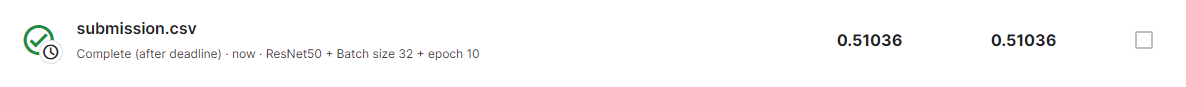

#### Attempt 3: ResNet50 + Batch size 32 + 15 epochs
Epoch 1, validation loss: 1.587479407372682, Accuracy: 68.47222222222223\
Epoch 2, validation loss: 0.8297898458397907, Accuracy: 82.5\
Epoch 3, validation loss: 0.6740319884341696, Accuracy: 81.80555555555556\
Epoch 4, validation loss: 0.6058755763199019, Accuracy: 82.08333333333333\
Epoch 5, validation loss: 0.6011326662872148, Accuracy: 82.08333333333333\
Epoch 6, validation loss: 0.5631853912187659, Accuracy: 83.05555555555556\
Epoch 7, validation loss: 0.529386892914772, Accuracy: 83.75\
Epoch 8, validation loss: 0.5275283883447233, Accuracy: 84.72222222222223\
Epoch 9, validation loss: 0.5301222153331923, Accuracy: 84.44444444444444\
Epoch 10, validation loss: 0.5557473632304565, Accuracy: 82.5\
Epoch 11, validation loss: 0.5069560544646304, Accuracy: 84.30555555555556\
Epoch 12, validation loss: 0.4918694774741712, Accuracy: 85.41666666666667\
Epoch 13, validation loss: 0.5193935823829278, Accuracy: 84.02777777777777\
Epoch 14, validation loss: 0.5081219925828602, Accuracy: 84.44444444444444\
Epoch 15, validation loss: 0.5059456630893375, Accuracy: 84.30555555555556\
Finished Training


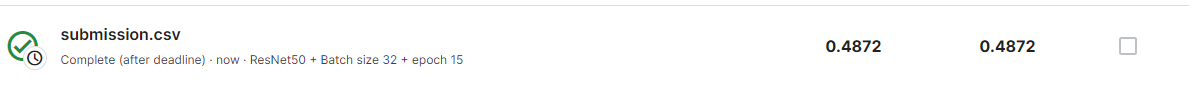


#### Attempt 4: ResNet50 + Batch size 32 + 20 epochs

Epoch 1, validation loss: 1.5330568603847339, Accuracy: 72.36111111111111\
Epoch 2, validation loss: 0.853749938633131, Accuracy: 80.97222222222223\
Epoch 3, validation loss: 0.65440647887147, Accuracy: 84.16666666666667\
Epoch 4, validation loss: 0.591194925100907, Accuracy: 84.16666666666667\
Epoch 5, validation loss: 0.5762657341749772, Accuracy: 82.63888888888889\
Epoch 6, validation loss: 0.5788702180852061, Accuracy: 82.77777777777777\
Epoch 7, validation loss: 0.5434042150559633, Accuracy: 83.61111111111111\
Epoch 8, validation loss: 0.511298686913822, Accuracy: 84.58333333333333\
Epoch 9, validation loss: 0.514881859007089, Accuracy: 84.30555555555556\
Epoch 10, validation loss: 0.5364260893800984, Accuracy: 83.33333333333333\
Epoch 11, validation loss: 0.5029880443344945, Accuracy: 84.44444444444444\
Epoch 12, validation loss: 0.5066732174676397, Accuracy: 84.02777777777777\
Epoch 13, validation loss: 0.49831912504590076, Accuracy: 84.44444444444444\
Epoch 14, validation loss: 0.49088133223678754, Accuracy: 83.19444444444444\
Epoch 15, validation loss: 0.47735740633114526, Accuracy: 85.97222222222223\
Epoch 16, validation loss: 0.5009107994644538, Accuracy: 85.13888888888889\
Epoch 17, validation loss: 0.5190728591836017, Accuracy: 84.30555555555556\
Epoch 18, validation loss: 0.5053637345199999, Accuracy: 84.16666666666667\
Epoch 19, validation loss: 0.49226549850857776, Accuracy: 84.02777777777777\
Epoch 20, validation loss: 0.5025080445667972, Accuracy: 84.02777777777777\
Finished Training



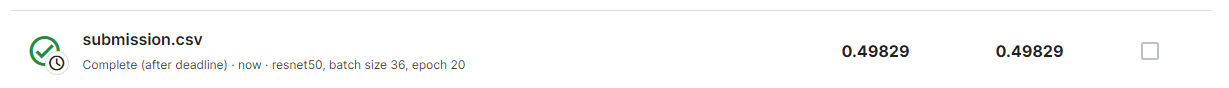

### Batch Size 64

#### Testing out ResNet50 + batch size 64 (double) + epoch 5

Epoch 1, validation loss: 2.8671755194664, Accuracy: 51.111111111111114\
Epoch 2, validation loss: 1.4915342032909393, Accuracy: 72.08333333333333\
Epoch 3, validation loss: 1.0024608025948207, Accuracy: 80.0\
Epoch 4, validation loss: 0.8081085284550985, Accuracy: 81.66666666666667\
Epoch 5, validation loss: 0.6952344154318174, Accuracy: 82.36111111111111\
Finished Training

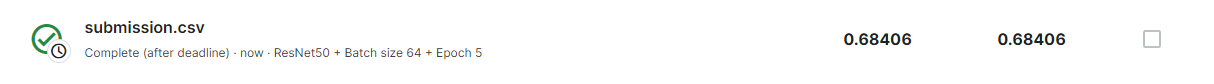


#### Testing out ResNet50 + batch size 64 (double) + epoch 10

Epoch 2, validation loss: 1.4989416698614757, Accuracy: 76.52777777777777\
Epoch 3, validation loss: 1.0280824452638626, Accuracy: 80.27777777777777\
Epoch 4, validation loss: 0.8047184298435847, Accuracy: 83.47222222222223\
Epoch 5, validation loss: 0.7095558966199557, Accuracy: 84.86111111111111\
Epoch 6, validation loss: 0.6322911754250526, Accuracy: 84.58333333333333\
Epoch 7, validation loss: 0.5998083750406901, Accuracy: 84.86111111111111\
Epoch 8, validation loss: 0.5748158022761345, Accuracy: 85.69444444444444\
Epoch 9, validation loss: 0.5494791020949682, Accuracy: 85.55555555555556\
Epoch 10, validation loss: 0.5245788395404816, Accuracy: 85.97222222222223\
Finished Training

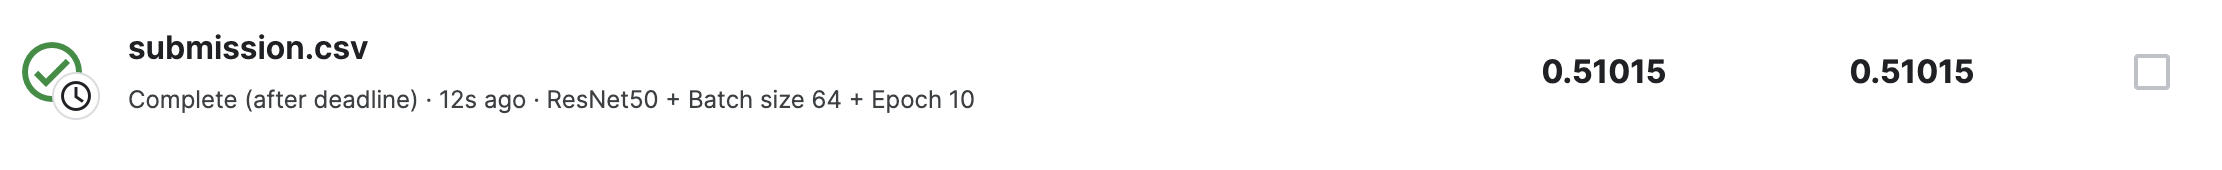

#### Testing out ResNet50 + batch size 64 (double) + epoch 15

Epoch 1, validation loss: 2.8610901633898416, Accuracy: 50.55555555555556\
Epoch 2, validation loss: 1.5219718217849731, Accuracy: 73.75\
Epoch 3, validation loss: 1.0231829981009166, Accuracy: 80.41666666666667\
Epoch 4, validation loss: 0.8261043628056844, Accuracy: 83.19444444444444\
Epoch 5, validation loss: 0.7154347822070122, Accuracy: 83.33333333333333\
Epoch 6, validation loss: 0.6530346622069677, Accuracy: 84.44444444444444\
Epoch 7, validation loss: 0.6077489157517751, Accuracy: 85.97222222222223\
Epoch 8, validation loss: 0.5906019906202952, Accuracy: 85.83333333333333\
Epoch 9, validation loss: 0.553759810825189, Accuracy: 86.25\
Epoch 10, validation loss: 0.5425938765207926, Accuracy: 84.44444444444444\
Epoch 11, validation loss: 0.5388124212622643, Accuracy: 84.72222222222223\
Epoch 12, validation loss: 0.5323742429415385, Accuracy: 85.27777777777777\
Epoch 13, validation loss: 0.5236495658755302, Accuracy: 85.55555555555556\
Epoch 14, validation loss: 0.5072312553723654, Accuracy: 85.41666666666667\
Epoch 15, validation loss: 0.49573448300361633, Accuracy: 85.55555555555556\
Finished Training

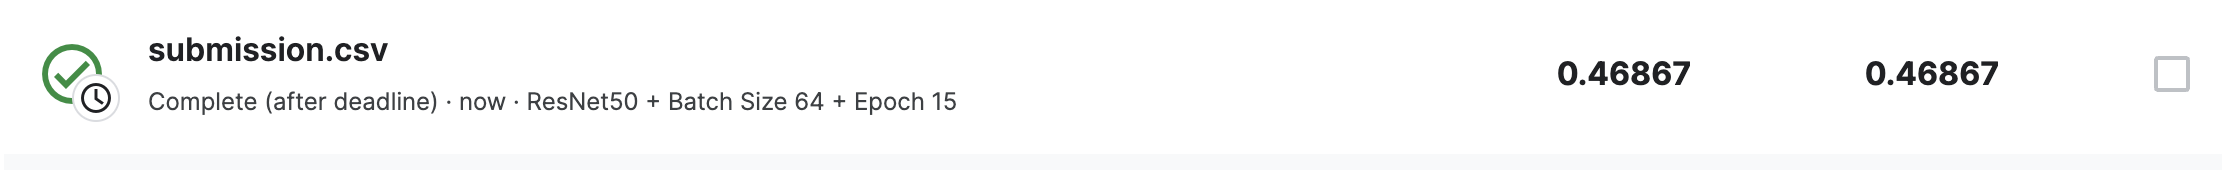




#### Testing out ResNet50 + batch size 64 (double) + epoch 20
Epoch 1, validation loss: 2.862304131189982, Accuracy: 53.888888888888886\
Epoch 2, validation loss: 1.5003412266572316, Accuracy: 73.47222222222223\
Epoch 3, validation loss: 1.020391618212064, Accuracy: 80.13888888888889\
Epoch 4, validation loss: 0.8246559600035349, Accuracy: 81.94444444444444\
Epoch 5, validation loss: 0.7134525328874588, Accuracy: 82.63888888888889\
Epoch 6, validation loss: 0.6412225812673569, Accuracy: 84.86111111111111\
Epoch 7, validation loss: 0.6059974854191145, Accuracy: 85.55555555555556\
Epoch 8, validation loss: 0.5654031907518705, Accuracy: 86.66666666666667\
Epoch 9, validation loss: 0.5533394093314806, Accuracy: 85.0\
Epoch 10, validation loss: 0.5279971833030382, Accuracy: 85.27777777777777\
Epoch 11, validation loss: 0.5238664795955023, Accuracy: 85.13888888888889\
Epoch 12, validation loss: 0.505061017970244, Accuracy: 84.16666666666667\
Epoch 13, validation loss: 0.4843536838889122, Accuracy: 86.11111111111111\
Epoch 14, validation loss: 0.5017544453342756, Accuracy: 84.72222222222223\
Epoch 15, validation loss: 0.4752624183893204, Accuracy: 85.0\
Epoch 16, validation loss: 0.47713472445805866, Accuracy: 86.80555555555556\
Epoch 17, validation loss: 0.47597967833280563, Accuracy: 86.25\
Epoch 18, validation loss: 0.4576185718178749, Accuracy: 86.25\
Epoch 19, validation loss: 0.47113653272390366, Accuracy: 85.55555555555556\
Epoch 20, validation loss: 0.46169502288103104, Accuracy: 85.55555555555556\
Finished Training

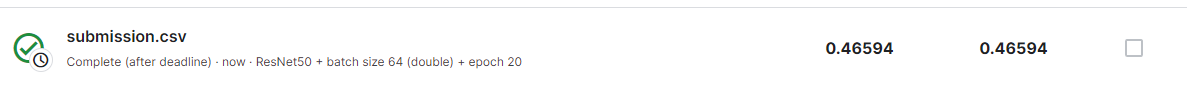




#### Testing out ResNet50 + batch size 64 (double) + epoch 30

Epoch 1, validation loss: 2.7937092781066895, Accuracy: 53.47222222222222\
Epoch 2, validation loss: 1.4952791432539623, Accuracy: 74.44444444444444\
Epoch 3, validation loss: 0.9996098528305689, Accuracy: 80.69444444444444\
Epoch 4, validation loss: 0.8001318623622259, Accuracy: 80.41666666666667\
Epoch 5, validation loss: 0.6804526050885519, Accuracy: 84.16666666666667\
Epoch 6, validation loss: 0.641857718427976, Accuracy: 83.61111111111111\
Epoch 7, validation loss: 0.5916464279095331, Accuracy: 85.27777777777777\
Epoch 8, validation loss: 0.5626320342222849, Accuracy: 84.02777777777777\
Epoch 9, validation loss: 0.5357477739453316, Accuracy: 84.58333333333333\
Epoch 10, validation loss: 0.5309907297293345, Accuracy: 85.83333333333333\
Epoch 11, validation loss: 0.5005863954623541, Accuracy: 85.41666666666667\
Epoch 12, validation loss: 0.49186254292726517, Accuracy: 85.13888888888889\
Epoch 13, validation loss: 0.48130002866188687, Accuracy: 86.80555555555556\
Epoch 14, validation loss: 0.4846036359667778, Accuracy: 85.13888888888889\
Epoch 15, validation loss: 0.47153109808762866, Accuracy: 85.97222222222223\
Epoch 16, validation loss: 0.48027457296848297, Accuracy: 85.0\
Epoch 17, validation loss: 0.46389955282211304, Accuracy: 87.5\
Epoch 18, validation loss: 0.48383959382772446, Accuracy: 85.27777777777777\
Epoch 19, validation loss: 0.4557224288582802, Accuracy: 85.0\
Epoch 20, validation loss: 0.4586045766870181, Accuracy: 86.25\
Epoch 21, validation loss: 0.4641527955730756, Accuracy: 85.27777777777777\
Epoch 22, validation loss: 0.4541548440853755, Accuracy: 86.25\
Epoch 23, validation loss: 0.4513811320066452, Accuracy: 86.66666666666667\
Epoch 24, validation loss: 0.4484410534302394, Accuracy: 86.66666666666667\
Epoch 25, validation loss: 0.436427208284537, Accuracy: 86.66666666666667\
Epoch 26, validation loss: 0.46876566981275875, Accuracy: 85.55555555555556\
Epoch 27, validation loss: 0.4470123077432315, Accuracy: 87.08333333333333\
Epoch 28, validation loss: 0.47064974904060364, Accuracy: 85.41666666666667\
Epoch 29, validation loss: 0.45773569246133167, Accuracy: 86.11111111111111\
Epoch 30, validation loss: 0.44847552478313446, Accuracy: 86.11111111111111\
Finished Training

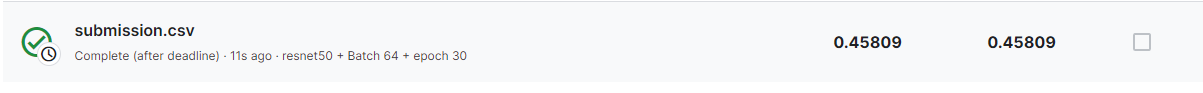

## Testing ResNet 152 with different batch size + epochs

### Batch size 16

#### Attempt 1: Starting with ResNet152 + Batch size 16 + 5 epochs

Epoch 1, validation loss: 0.7529494914743635, Accuracy: 81.66666666666667\
Epoch 2, validation loss: 0.5221489040388001, Accuracy: 85.13888888888889\
Epoch 3, validation loss: 0.4982397390736474, Accuracy: 84.02777777777777\
Epoch 4, validation loss: 0.5137336272332403, Accuracy: 83.47222222222223\
Epoch 5, validation loss: 0.4315767102771335, Accuracy: 85.0\
Finished Training

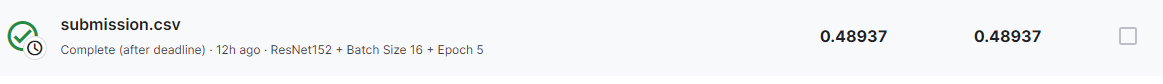

#### Attempt 2: ResNet152 + Batch size 16 + 10 epochs

Epoch 1, validation loss: 0.7648761762513054, Accuracy: 81.94444444444444\
Epoch 2, validation loss: 0.531511726644304, Accuracy: 84.72222222222223\
Epoch 3, validation loss: 0.5175290298130777, Accuracy: 84.02777777777777\
Epoch 4, validation loss: 0.47918833014037876, Accuracy: 84.72222222222223\
Epoch 5, validation loss: 0.5000326005121072, Accuracy: 85.13888888888889\
Epoch 6, validation loss: 0.5529877588152885, Accuracy: 82.63888888888889\
Epoch 7, validation loss: 0.47973568447762066, Accuracy: 85.13888888888889\
Epoch 8, validation loss: 0.552337632411056, Accuracy: 82.5\
Epoch 9, validation loss: 0.5951809455123213, Accuracy: 81.25\
Epoch 10, validation loss: 0.5449907357907957, Accuracy: 82.22222222222223\
Finished Training

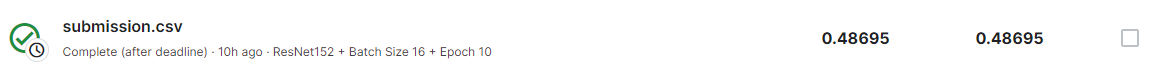

#### Attempt 3: ResNet152 + Batch size 16 + 15 epochs

Epoch 1, validation loss: 0.7551161736249924, Accuracy: 79.86111111111111\
Epoch 2, validation loss: 0.5463025606340832, Accuracy: 83.05555555555556\
Epoch 3, validation loss: 0.5518472078773711, Accuracy: 82.22222222222223\
Epoch 4, validation loss: 0.4995073177748256, Accuracy: 82.77777777777777\
Epoch 5, validation loss: 0.4935434349709087, Accuracy: 83.88888888888889\
Epoch 6, validation loss: 0.4819008472065131, Accuracy: 84.58333333333333\
Epoch 7, validation loss: 0.5160509495271577, Accuracy: 82.36111111111111\
Epoch 8, validation loss: 0.503267088946369, Accuracy: 83.05555555555556\
Epoch 9, validation loss: 0.49436454930239254, Accuracy: 83.47222222222223\
Epoch 10, validation loss: 0.5248107734653685, Accuracy: 84.44444444444444\
Epoch 11, validation loss: 0.5206445364488496, Accuracy: 83.61111111111111\
Epoch 12, validation loss: 0.5104073661896917, Accuracy: 83.88888888888889\
Epoch 13, validation loss: 0.5474932778212759, Accuracy: 82.91666666666667\
Epoch 14, validation loss: 0.5964171482457055, Accuracy: 82.22222222222223\
Epoch 15, validation loss: 0.609161036585768, Accuracy: 82.36111111111111\
Finished Training

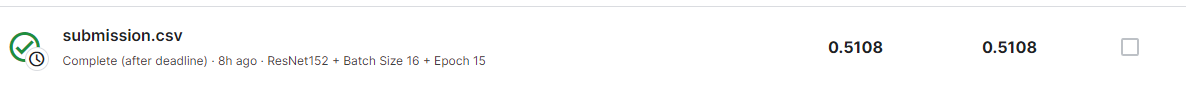

# Testing with LR Scheduler (Step Size 10 + Gamma 0.1)

## ResNet18 + Batch size 16 + Epoch 20

Epoch 0 current LR = [0.001]\
Epoch 1, validation loss: 1.598095428943634, Accuracy: 59.30555555555556\
Epoch 1 current LR = [0.001]\
Epoch 2, validation loss: 1.100465750032001, Accuracy: 67.36111111111111\
Epoch 2 current LR = [0.001]\
Epoch 3, validation loss: 0.9826018528805839, Accuracy: 72.08333333333333\
Epoch 3 current LR = [0.001]\
Epoch 4, validation loss: 0.8744850330882602, Accuracy: 72.63888888888889\
Epoch 4 current LR = [0.001]\
Epoch 5, validation loss: 0.8626455027196143, Accuracy: 73.61111111111111\
Epoch 5 current LR = [0.001]\
Epoch 6, validation loss: 0.8138694769806332, Accuracy: 75.13888888888889\
Epoch 6 current LR = [0.001]\
Epoch 7, validation loss: 0.824012291762564, Accuracy: 73.19444444444444\
Epoch 7 current LR = [0.001]\
Epoch 8, validation loss: 0.8019823071029452, Accuracy: 76.80555555555556\
Epoch 8 current LR = [0.001]\
Epoch 9, validation loss: 0.834412779741817, Accuracy: 74.30555555555556\
Epoch 9 current LR = [0.001]\
Epoch 10, validation loss: 0.7880369805627399, Accuracy: 76.52777777777777\
Epoch 10 current LR = [0.0001]\
Epoch 11, validation loss: 0.705457402434614, Accuracy: 78.61111111111111\
Epoch 11 current LR = [0.0001]\
Epoch 12, validation loss: 0.6930666743053331, Accuracy: 78.88888888888889\
Epoch 12 current LR = [0.0001]\
Epoch 13, validation loss: 0.6818974438640807, Accuracy: 79.58333333333333\
Epoch 13 current LR = [0.0001]\
Epoch 14, validation loss: 0.6759200543165207, Accuracy: 79.16666666666667\
Epoch 14 current LR = [0.0001]\
Epoch 15, validation loss: 0.6653122870458497, Accuracy: 79.58333333333333\
Epoch 15 current LR = [0.0001]\
Epoch 16, validation loss: 0.6725335852967368, Accuracy: 80.0\
Epoch 16 current LR = [0.0001]\
Epoch 17, validation loss: 0.6645769480201933, Accuracy: 80.41666666666667\
Epoch 17 current LR = [0.0001]\
Epoch 18, validation loss: 0.6684986321462525, Accuracy: 78.75\
Epoch 18 current LR = [0.0001]\
Epoch 19, validation loss: 0.6590491869383388, Accuracy: 79.16666666666667\
Epoch 19 current LR = [0.0001]\
Epoch 20, validation loss: 0.6639070807231797, Accuracy: 80.41666666666667
Finished Training

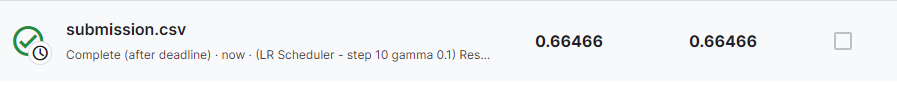

### Improvement 0.79415 to 0.66466 while using Learning Rate Scheduler (With same batch size & epoch)

## ResNet18 + Batch size 16 + Epoch 30

## ResNet18 + Batch size 16 + Epoch 40

## ResNet18 + Batch size 32 + Epoch 20

## ResNet18 + Batch size 32 + Epoch 30

## ResNet18 + Batch size 32 + Epoch 40

## ResNet18 + Batch size 16 + Epoch 20